### basic creation of tensors

### fashion classifer

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T # package to preprocess images

torch.manual_seed(26) # random seed setter
transform = T.Compose([T.ToTensor(), ## converts images to a tensor based on pixels
                       T.Normalize([0.5], [0.5])]) # normalizes the values from -1 to 1, allow gradient descent to opperate more effeceintely

trainset = torchvision.datasets.FashionMNIST(root=".", # where to save info
                                             train=True, # specify if its a training or test set
                                             download= True, # download the data to computer
                                             transform=transform) # transformsdata 
testset=torchvision.datasets.FashionMNIST(root=".",
                                           train=False,
                                           download=True,
                                           transform=transform)
print(trainset[0])


(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -

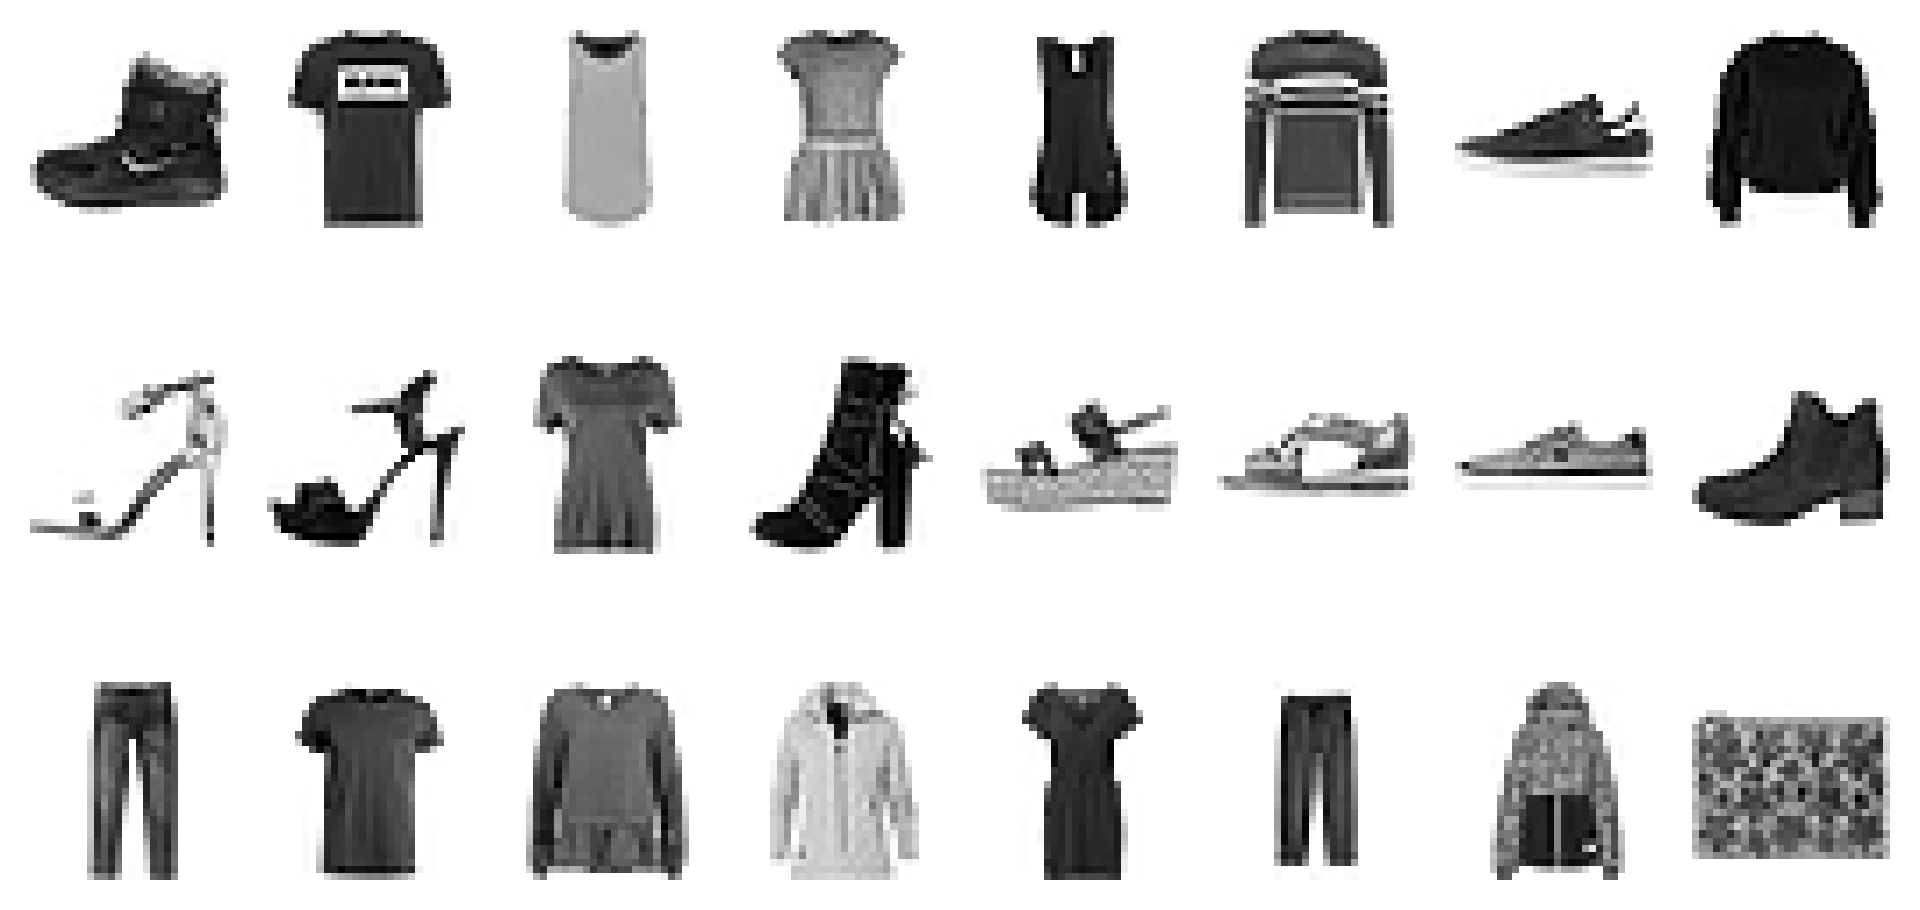

In [12]:
import matplotlib.pyplot as plt
plt.figure(dpi=300, figsize=(8,4))
for i in range(24):
    ax=plt.subplot(3, 8, i + 1) # where to put image
    img = trainset[i][0]
    img = img/2+0.5 # makes the val postive
    img = img.reshape(28, 28) # makes image 28 by 28
    plt.imshow(img, cmap="binary")
    plt.axis("off")
plt.show()

text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
             'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'] # labels of things in dataset

In [13]:
binary_train_set=[x for x in trainset if x[1] in [0,9]]
binary_test_set=[x for x in testset if x[1] in [0,9]]


In [14]:
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader


batch_size = 64 # how many training examples are used before a model is updated, loss is calc after and then weights updated

binary_train_loader=torch.utils.data.DataLoader(binary_train_set, # batches for training
                                                batch_size=batch_size, # amount of batches
                                                shuffle=True) # shuffle the observations

binary_test_loader=torch.utils.data.DataLoader(
    binary_test_set, # same thing for the test set
    batch_size=batch_size, shuffle=True)

In [15]:
print(torch.cuda.is_available())

True


In [16]:
import torch.nn as nn

device="cuda" # use cuda device if it is an option

# the number chosen for the the hidden layers are arbitratry but the numbers are used bc of the image of them
binary_model = nn.Sequential(
    nn.Linear(28*28, 256), # create a linear trasnfomration of data
    nn.LeakyReLU(), # decides if a nueron should be turned on based on ther weighted sum, intoduces non lineratry. 
    nn.Linear(256,128),
    nn.LeakyReLU(),
    nn.Linear(128,32),
    nn.LeakyReLU(),
    nn.Linear(32,1),
    nn.Dropout(p=0.25), # 25% chance a nueron would be dropped, this reduces overfitting making one neuron not resposnible for everything, also improves regualrization
    nn.Sigmoid().to("cuda") # applies sigmond activation function
)

In [17]:
lr=0.001 # learning rate, how much a model adjusts based on the loss function
# setting learning rate is subjective, most optimizers use 0.001 as a default

optimizer = torch.optim.Adam(binary_model.parameters(), lr=lr) # adam optim is a version of gradient descent, takes into consideration gradients in previous itterations unlike normal grad descent
loss_fn=nn.BCELoss() # cross entropy loss increase as the prob diverges from actual label

In [ ]:
# Move model to device
binary_model = binary_model.to(device)

for i in range(50): # train for 50 rounds through the entire dataset, not 50 batches
    tloss = 0.0
    n = 0
    for batch_idx, (imgs, labels) in enumerate(binary_train_loader): # iterates through all the images and labels in the batches of the dataset
        imgs = imgs.reshape(-1, 28*28).to(device) # flatten the images and move to device
        labels = torch.FloatTensor([1 if x.item()==9 else 0 for x in labels]).to(device).reshape(-1, 1) # convert labels to binary 0 and 1
        preds = binary_model(imgs) # predictions
        loss = loss_fn(preds, labels) # calculate the loss of the model
        optimizer.zero_grad() # resets the gradients to 0 which is important because it accumulates 
        loss.backward() # back prop to determine weights
        optimizer.step() # updates weights based on this 
        tloss += loss.item() # add the loss from that training round 
        n = batch_idx + 1
    tloss = tloss/n # loss on average per training round
    print(f"at epoch {i}, loss is {tloss:.4f}")
# use torch where to change this into predections, less then 0.5 we get a zero and greater we get a 1

at epoch 0, loss is 0.1909
at epoch 1, loss is 0.1727
at epoch 2, loss is 0.1791
at epoch 3, loss is 0.1751
at epoch 4, loss is 0.1746
at epoch 5, loss is 0.1716
at epoch 6, loss is 0.1684
at epoch 7, loss is 0.1804
at epoch 8, loss is 0.1744
at epoch 9, loss is 0.1653
at epoch 10, loss is 0.1708
at epoch 11, loss is 0.1717
at epoch 12, loss is 0.1705
at epoch 13, loss is 0.1729
at epoch 14, loss is 0.1714
at epoch 15, loss is 0.1754
at epoch 16, loss is 0.1702
at epoch 17, loss is 0.1748
at epoch 18, loss is 0.1730
at epoch 19, loss is 0.1718
at epoch 20, loss is 0.1750
at epoch 21, loss is 0.1678
at epoch 22, loss is 0.1733
at epoch 23, loss is 0.1755
at epoch 24, loss is 0.1674
at epoch 25, loss is 0.1729
at epoch 26, loss is 0.1788
at epoch 27, loss is 0.1771
at epoch 28, loss is 0.1777
at epoch 29, loss is 0.1784
at epoch 30, loss is 0.1713
at epoch 31, loss is 0.1762
at epoch 32, loss is 0.1725
at epoch 33, loss is 0.1730
at epoch 34, loss is 0.1757
at epoch 35, loss is 0.1746
at

In [19]:
import numpy as np
results = []

for imgs, labels in binary_test_loader: # all batches in the test set
    imgs=imgs.reshape(-1, 28*28).to(device)
    labels = (labels/9).reshape(-1,1).to(device)
    preds=binary_model(imgs) # makes preds using the trained model
    pred10=torch.where(preds>0.5,1,0) # comapres to labels
    correct=(pred10==labels)
    results.append(correct.detach().cpu().numpy().mean())  # accuracry in test set
accuracy = np.array(results).mean() # accuracy for test set
print(f"the accuracy of the predictions is {accuracy}")


the accuracy of the predictions is 0.87646484375


adding validaition set and early stopping

In [23]:
# First filter the dataset
filtered_trainset = [x for x in trainset if x[1] in [0,9]]

# Calculate the split sizes based on the filtered dataset length
total_size = len(filtered_trainset)
train_size = int(0.83 * total_size)  # Approximately same ratio as original split
val_size = total_size - train_size

# Now split the filtered dataset
trainset, valset = torch.utils.data.random_split(filtered_trainset, [train_size, val_size])

# Filter testset
testset = [x for x in testset if x[1] in [0,9]]

# load all the data into torch
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

# create early stopping class
class EarlyStop:
    def __init__(self, patience = 10): # when the class is intialized, a constructor
        # patience is the amount of steps without an improvement when it will stop
        self.patience = patience
        self.steps = 0 # var that tracks steps without improvement
        self.min_loss = float('inf') # ensures first val loss will always be less, stores the bets val loss 
    def stop(self, val_loss): # when to stop, takes the loss from the class and comapres it
        if val_loss < self.min_loss: # if preformance has improved
            self.min_loss = val_loss
            self.steps = 0
        elif val_loss >= self.min_loss:
            self.steps += 1
        if self.steps >= self.patience: # if true is returned stop the training process
            return True
        else:
            return False
stopper = EarlyStop()

# create model
model = nn.Sequential(
    nn.Linear(28*28, 512), # create a linear trasnfomration of data
    nn.LeakyReLU(), # decides if a nueron should be turned on based on ther weighted sum, intoduces non lineratry. 
    nn.Linear(512,256),
    nn.LeakyReLU(),
    nn.Linear(256,128),
    nn.LeakyReLU(),
    nn.Linear(128,64),
    nn.LeakyReLU(),
    nn.Linear(64,32),
    nn.LeakyReLU(),
    nn.Linear(32,1),
    nn.Dropout(p=0.25), # 25% chance a nueron would be dropped, this reduces overfitting making one neuron not resposnible for everything, also improves regualrization
    nn.Sigmoid() # applies sigmond activation function
)

# ensure model is on GPU
model = model.to(device)

# training rounds function
def train_epoch():
    tloss = 0
    for n, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.reshape(-1, 28*28).to(device)
        labels = torch.FloatTensor([1 if x.item()==9 else 0 for x in labels]).to(device).reshape(-1, 1) # select only the two labels
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad() # gradient 
        loss.backward()
        optimizer.step()
        tloss += loss.detach()
    return tloss/n

# loss on the validation set which the model hasnt seen
def val_epoch():
    vloss = 0
    for n,(imgs, labels) in enumerate(val_loader):
        imgs=imgs.reshape(-1, 28*28).to(device)
        labels = torch.FloatTensor([1 if x.item()==9 else 0 for x in labels]).to(device).reshape(-1, 1)
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        vloss+=loss.detach()
    return vloss /n

for i in range (1, 101):
    tloss = train_epoch()
    vloss = val_epoch()
    print(f"at epoch {i}, tloss is {tloss}, vloss is {vloss}")
    if stopper.stop(vloss)==True:             
        break  

for imgs, labels in binary_test_loader: 
    imgs=imgs.reshape(-1, 28*28).to(device) # flatten images
    labels = (labels/9).reshape(-1,1).to(device) # reshape the labels 
    preds=binary_model(imgs) 
    pred10=torch.where(preds>0.5,1,0)
    correct=(pred10==labels)
    results.append(correct.detach().cpu().numpy().mean())  
accuracy = np.array(results).mean() 
print(f"the accuracy of the predictions is {accuracy}")

at epoch 1, tloss is 0.6991031169891357, vloss is 0.7256186008453369
at epoch 2, tloss is 0.6991012692451477, vloss is 0.7257018685340881
at epoch 3, tloss is 0.6991026997566223, vloss is 0.7256794571876526
at epoch 4, tloss is 0.6990918517112732, vloss is 0.7257450222969055
at epoch 5, tloss is 0.6990567445755005, vloss is 0.7256930470466614
at epoch 6, tloss is 0.6990883350372314, vloss is 0.725608766078949
at epoch 7, tloss is 0.6990923881530762, vloss is 0.7256612181663513
at epoch 8, tloss is 0.6991143226623535, vloss is 0.7257064580917358
at epoch 9, tloss is 0.6990905404090881, vloss is 0.7256585955619812
at epoch 10, tloss is 0.6990903615951538, vloss is 0.7256885170936584
at epoch 11, tloss is 0.699082612991333, vloss is 0.7257933616638184
at epoch 12, tloss is 0.699114203453064, vloss is 0.725714385509491
at epoch 13, tloss is 0.6991006731987, vloss is 0.7256785035133362
at epoch 14, tloss is 0.6990848779678345, vloss is 0.7256684303283691
at epoch 15, tloss is 0.699101984500